In [6]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from ipyfilechooser import FileChooser

from alvra_tools import *
import glob

In [2]:
scan_name ="Na2SO4_monoscan_1"

DIR_json = "/sf/alvra/data/p18741/raw/scan_info/"
DIR = "/sf/alvra/data/p18741/raw/scan_data/" + scan_name + "/"             #use this for a scan

#######################################################################

!ls -lah -rt $DIR | grep BSREAD.h5
!hostname

-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002120.BSREAD.h5
-rw-r--r--. 1 root p18741 114M Nov 25 17:34 run_002122.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002110.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002118.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002111.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002133.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002130.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002119.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002128.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002129.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002112.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002131.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002113.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002140.BSREAD.h5
-rw-r--r--. 1 root p18741 115M Nov 25 17:34 run_002136.BSREAD.h5
-rw-r--r--. 1 root p18741

# Load one step and check I0 filtering


--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 50.0 Hz
Energy = 2486.0037538467213 eV
Median value Izero (all) = 0.13510236330330372
Median value fluo (all) = 0.44326993734529707


<IPython.core.display.Javascript object>


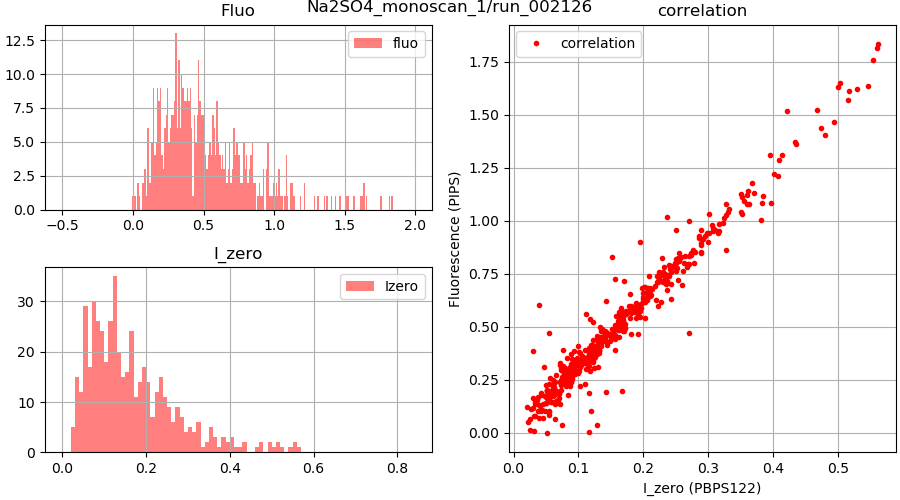

In [3]:
f ="run_002126.BSREAD.h5"
fn = DIR + f

channel_list = [channel_PIPS_fluo, channel_Izero122, channel_energy]

results = load_data_compact(channel_list, fn)

#(DataTrans_shot, DataFluo_shot, IzeroFEL_shot, Laser, Energy_shot, PulseIDs) = load_FEL_scans(fn, channel_energy)

Energy_shot   = results[channel_energy]
IzeroFEL_shot = results[channel_Izero122]
DataFluo_shot = results[channel_PIPS_fluo]

IzeroFEL_shot_raw = IzeroFEL_shot.copy()
#DataTrans_shot_raw = DataTrans_shot.copy()
DataFluo_shot_raw = DataFluo_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero (all) = {}".format(np.median(IzeroFEL_shot_raw)))
print ("Median value fluo (all) = {}".format(np.median(DataFluo_shot_raw)))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(scan_name +"/"+ f.split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluo_shot, bins =np.arange(-0.5,2,0.01), facecolor='red', label="fluo", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label='Izero', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_shot, DataFluo_shot, color = 'red',  linestyle='None', label='correlation',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (PIPS)")

plt.show()

# Load mono scan

In [7]:
fc = FileChooser('/sf/alvra/data/p18741/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18741/raw/scan_info', filename='', show_hidden='False')

### First, without any filtering of the data, check data distributions with quantiles 

In [9]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

channel_list = [channel_PIPS_fluo, channel_Izero122, channel_energy]

######################################################33
json_file = fc.selected
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo = []
Energy_eV = []

for i in range(0,numFiles):             
    fn = str(data['scan_files'][i][0])    
    exists = os.path.isfile(fn)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        results = load_data_compact(channel_list, fn)

        #(DataTrans_shot, DataFluo_shot, IzeroFEL_shot, Laser, Energy_shot, PulseIDs) = load_FEL_scans(fn, channel_energy)
        
        Energy_shot   = results[channel_energy]
        IzeroFEL_shot = results[channel_Izero122]
        DataFluo_shot = results[channel_PIPS_fluo]
        
        print ("Loaded {} shots".format(len(DataFluo_shot)))
    
        DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
        
        df_fluo = pd.DataFrame(DataFluo_shot_norm)
              
        DataFluo.append(np.nanquantile(df_fluo, quantiles))        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo = np.asarray(DataFluo)
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")

step 31 of 31 : Processing /sf/alvra/data/p18741/raw/scan_data/Na2SO4_monoscan_1/run_002140.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 50.0 Hz
Loaded 500 shots
Job done!


<IPython.core.display.Javascript object>


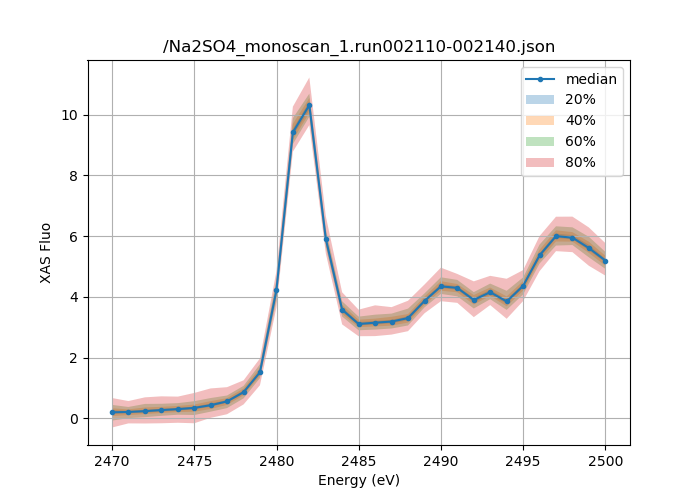

In [10]:
plt.figure(figsize = (7,5))

plt.plot(Energy_eV, DataFluo[:,0],label='median',marker='.' )
plt.fill_between(Energy_eV,np.array(DataFluo[:,4]),np.array(DataFluo[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,3]),np.array(DataFluo[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,2]),np.array(DataFluo[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,1]),np.array(DataFluo[:,8]), label='80%', alpha = 0.3)
plt.grid()

plt.legend(loc="best")
plt.ylabel("XAS Fluo")
plt.xlabel("Energy (eV)")
plt.title(json_file.split('scan_info')[1], fontsize=12)

plt.show()

### Now choose thresholds and quantile

In [12]:
min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.5

channel_list = [channel_PIPS_fluo, channel_Izero122, channel_energy]

########################################################################
json_file = fc.selected
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo = []
Energy_eV = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        results = load_data_compact(channel_list, filename)
        
        #(DataTrans_shot, DataFluo_shot, IzeroFEL_shot, Laser, Energy_shot, PulseIDs) = load_FEL_scans(filename, channel_energy)
        
        Energy_shot   = results[channel_energy]
        IzeroFEL_shot = results[channel_Izero122]
        DataFluo_shot = results[channel_PIPS_fluo]
        
        print ("Loaded {} shots".format(len(DataFluo_shot)))
        
        threshold_FEL = IzeroFEL_shot > min_I0
        threshold_fluo = DataFluo_shot > min_fluo
        thresholds_filter = threshold_FEL & threshold_fluo
        DataFluo_shot = DataFluo_shot[thresholds_filter]
        IzeroFEL_shot = IzeroFEL_shot[thresholds_filter]
        
        print ("survived {} shots".format(len(DataFluo_shot)))
        
        DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
        
        med = np.median(DataFluo_shot_norm)
        qnt_low = np.nanquantile(DataFluo_shot_norm, 0.5 - quantile_corr/2)
        qnt_high = np.nanquantile(DataFluo_shot_norm, 0.5 + quantile_corr/2)
        condition_corr_low = DataFluo_shot_norm > qnt_low
        condition_corr_high = DataFluo_shot_norm < qnt_high
        correlation_filter = condition_corr_low & condition_corr_high 
        DataFluo_shot_norm = DataFluo_shot_norm[correlation_filter]
        
        print ("survived {} shots".format(len(DataFluo_shot_norm)))
        
        df_fluo = pd.DataFrame(DataFluo_shot_norm)
        DataFluo.append(np.nanquantile(df_fluo, [0.5, 0, 1]))
        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo = np.asarray(DataFluo)                  
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")

step 31 of 31 : Processing /sf/alvra/data/p18741/raw/scan_data/Na2SO4_monoscan_1/run_002140.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 50.0 Hz
Loaded 500 shots
survived 496 shots
survived 248 shots
Job done!


<IPython.core.display.Javascript object>


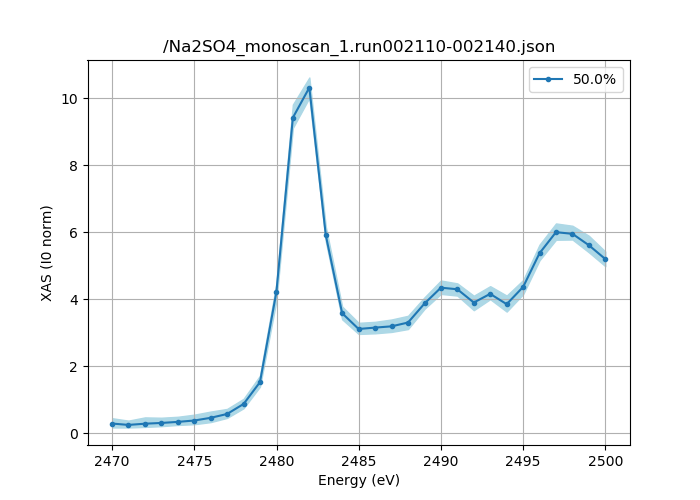

In [13]:
plt.figure(figsize = (7,5))

XAS = DataFluo[:,0]
err_low = DataFluo[:,1]
err_high = DataFluo[:,2]

plt.plot(Energy_eV, XAS, label='{}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV, err_low, err_high, color='lightblue')
plt.xlabel("Energy (eV)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.title(json_file.split('scan_info')[1], fontsize=12)
plt.grid()

plt.show()